# Laplacian边缘检测

In [1]:
import numpy as np
import cupy as cp
import cv2
import string
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [24]:
def load_kernel(src,kname):
    _ = cp.zeros((1,)) # 初始化cuda context
    kernel = cp.core.core.compile_with_cache(src).get_function(kname)
    return kernel

In [35]:
sources = string.Template("""
extern "C" {

__device__ int KerSobel(int a1, int a2, int a3, int a4, int a5, int a6)
{
    return(a1 + 2 * a2 + a3 - (a4 + 2 * a5 + a6));
}

__global__ void laplacian_filter(unsigned int *lpSrc,unsigned int *lpDst,  int width, int height,int* gc_weight, int amplitude)
{
    int   x = blockIdx.x * blockDim.x + threadIdx.x;
    int  y = blockIdx.y * blockDim.y + threadIdx.y;
    int idx  = width * y + x;
    int xy[9];
    int dr, dg, db;
    int powR, powG, powB;

    if(x >= 1 && x < width - 1 && y >= 1 && y < height - 1)
    {
        /*lpDst[idx] = 8 * lpSrc[idx] -
            lpSrc[idx - 1] - lpSrc[idx + 1] -
            lpSrc[idx - width] - lpSrc[idx + width] -
            lpSrc[idx - width - 1] - lpSrc[idx + width + 1] -
            lpSrc[idx - width + 1] - lpSrc[idx + width - 1];
        */

        xy[0]= lpSrc[idx - width - 1];
        xy[1]= lpSrc[idx - width];
        xy[2]= lpSrc[idx - width + 1];
        xy[3]= lpSrc[idx - 1];
        xy[4]= lpSrc[idx];
        xy[5]= lpSrc[idx + 1];
        xy[6]= lpSrc[idx + width - 1];
        xy[7]= lpSrc[idx + width];
        xy[8]= lpSrc[idx + width + 1];

        dr = dg = db = 0;

        for(int i = 0; i < 9; i ++)
        {
            dr += gc_weight[i] * (0xFF & (xy[i] >> 16));
            dg += gc_weight[i] * (0xFF & (xy[i] >> 8));
            db += gc_weight[i] * (0xFF & (xy[i]));
        }

        /* Calculate power */
        powR = amplitude * dr * dr >> 10; // * amplitude / 1024
        powG = amplitude * dg * dg >> 10;
        powB = amplitude * db * db >> 10;
        if(powR > 255) { powR = 255; }
        if(powG > 255) { powG = 255; }
        if(powB > 255) { powB = 255; }

        lpDst[y * width + x] = (powR << 16) | (powG << 8) | (powB);
     }
}


}
""").substitute()

In [4]:
src = cv2.imread('../../datas/f2.jpg',0)

In [36]:
detect_edge = load_kernel(sources,'laplacian_filter')

In [37]:
height,width = src.shape
dim_block = (32,32)
grid = ((dim_block[0] + width - 1) // dim_block[0],
        (dim_block[1] + height - 1) // dim_block[1])
src_cu = cp.asarray(src).astype(cp.uint32)
dst_cu = cp.zeros(src.shape,dtype=cp.uint32)
weight = cp.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1]
],dtype=cp.int32)

In [57]:
detect_edge(grid=grid,block=dim_block,args=(src_cu,dst_cu,width,height,weight,128))

In [58]:
dst = dst_cu.get()
dst[dst < 0] = 0
dst[dst > 255] = 255
dst = np.uint8(np.abs(dst))

([], <a list of 0 Text yticklabel objects>)

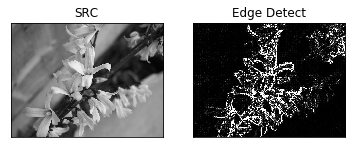

In [59]:
plt.subplot(121)
plt.imshow(src,'gray')
plt.title('SRC')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(dst,'gray')
plt.title('Edge Detect')
plt.xticks([])
plt.yticks([])